# Comp255 - Assessment 1 (45431957)

In [1]:
# import packages
import numpy as np 
import pandas as pd 
from scipy import signal

from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

1) Load Dataset:
2) Visualise Dataset:

'''
At first, we should explore the raw time-series sensor data. We could draw line plot of sensor signals.
'''

In [3]:
# 1) read/load dataset file
for i in range(19):
    df = pd.read_csv('dataset/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
    print('The dataset contains %d rows.' % len(df))



The dataset contains 245576 rows.
The dataset contains 301901 rows.
The dataset contains 245985 rows.
The dataset contains 248239 rows.
The dataset contains 254178 rows.
The dataset contains 224073 rows.
The dataset contains 261959 rows.
The dataset contains 231653 rows.
The dataset contains 248855 rows.
The dataset contains 242709 rows.
The dataset contains 240251 rows.
The dataset contains 254794 rows.
The dataset contains 246190 rows.
The dataset contains 244144 rows.
The dataset contains 241272 rows.
The dataset contains 255201 rows.
The dataset contains 239838 rows.
The dataset contains 229396 rows.
The dataset contains 230628 rows.


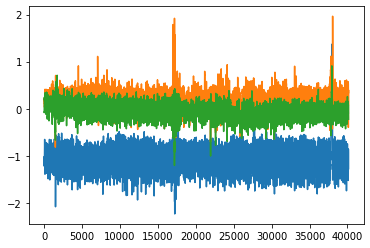

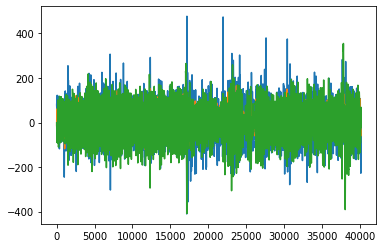

In [6]:
#2) Visualising


# Accelerometer data (column 1 to 3)
df_walking = df[df[24] == 7].values
plt.plot(df_walking[:, 0:3])
plt.show()

# Gyroscope data (column 3 to 6)
df_walking2 = df[df[24] == 7].values
plt.plot(df_walking2[:, 3:6])
plt.show()


# Accelerometer data (column 1 to 3)
# for i in range(19):
#    df_acc = df[df[24] == (i+1)].values
#    plt.plot(df_acc[:, 0:3])
# plt.show()

# Gyroscope data (column 3 to 6)
# for i in range(19):
#    df_gyr = df[df[24] == (i+1)].values
#    plt.plot(df_gyr[:, 3:6])
# plt.show()

3) Remove signal noises

'''
For raw sensor data, it usually contains noise that arises from different sources, such as sensor mis-
calibration, sensor errors, errors in sensor placement, or noisy environments. We could apply filter to remove noise of sensor data
to smooth data. Butterworth low-pass filter is applied. 
'''

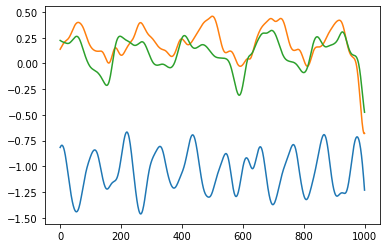

In [10]:
# def noise_removing():
for i in range(19):
    df = pd.read_csv('dataset/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
    # Butterworth low-pass filter. Chebyshev also tested. Both with 500-1500 as the parameters
b, a = signal.butter(4, 0.04, 'low', analog=False)
df_walking = df[df[24] == 7].values
for i in range(3):
    df_walking[:,i] = signal.lfilter(b, a, df_walking[:, i])
plt.plot(df_walking[500:1500, 0:3])
plt.show()

4-5) Extract features/prepare training set

'''
To build a human activity recognition system, we need to extract features from raw data and create feature dataset for training machine learning models.
'''

In [6]:
#def feature_engineering_example():
training = np.empty(shape=(0, 10))
testing = np.empty(shape=(0, 10))
# deal with each dataset file
for i in range(19):
    df = pd.read_csv('dataset/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
    print('deal with dataset ' + str(i + 1))
    for c in range(1, 14):
        activity_data = df[df[24] == c].values
        # remove noises
        b, a = signal.butter(4, 0.04, 'lowpass', analog=False)
        for j in range(24):
            activity_data[:, j] = signal.lfilter(b, a, activity_data[:, j])
            
        datat_len = len(activity_data)
        training_len = math.floor(datat_len * 0.8)
        training_data = activity_data[:training_len, :]
        testing_data = activity_data[training_len:, :]

        # data segementation: for time series data, we need to segment the whole time series, and then extract features from each period of time
        # to represent the raw data. Defined each period of time contains 1000 data points. Each period of time contains 
        # different data points. You may consider overlap segmentation, which means consecutive two segmentation share a part of data points, to 
        # get more feature samples.
        training_sample_number = training_len // 1000 + 1
        testing_sample_number = (datat_len - training_len) // 1000 + 1
        
        for s in range(training_sample_number):
            if s < training_sample_number - 1:
                sample_data = training_data[1000*s:1000*(s + 1), :]
            else:
                sample_data = training_data[1000*s:, :]
            # in this example code, only three accelerometer data in wrist sensor is used to extract three simple features: min, max, and mean value in
            # a period of time. Finally we get 9 features and 1 label to construct feature dataset. You may consider all sensors' data and extract more

            feature_sample = []
            for i in range(3):
                feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(np.var(sample_data[:, i]))
                feature_sample.append(kurtosis(sample_data[:, i]))
                # feature_sample.append(skew(sample_data[:, i]))
                # feature_sample.append(kurtosis(sample_data[:, i]))
            feature_sample.append(sample_data[0, -1])
            feature_sample = np.array([feature_sample])
            training = np.concatenate((training, feature_sample), axis=0)
            
        for s in range(testing_sample_number):
            if s < training_sample_number - 1:
                sample_data = testing_data[1000*s:1000*(s + 1), :]
            else:
                sample_data = testing_data[1000*s:, :]

            feature_sample = []
            for i in range(3):
                feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(np.var(sample_data[:, i]))
                feature_sample.append(kurtosis(sample_data[:, i]))
                # feature_sample.append(skew(sample_data[:, i]))
                # feature_sample.append(kurtosis(sample_data[:, i]))
            feature_sample.append(sample_data[0, -1])
            feature_sample = np.array([feature_sample])
            testing = np.concatenate((testing, feature_sample), axis=0)

df_training = pd.DataFrame(training)
df_testing = pd.DataFrame(testing)
df_training.to_csv('training_data.csv', index=None, header=None)
df_testing.to_csv('testing_data.csv', index=None, header=None)

deal with dataset 1
deal with dataset 2
deal with dataset 3
deal with dataset 4
deal with dataset 5
deal with dataset 6
deal with dataset 7
deal with dataset 8
deal with dataset 9
deal with dataset 10
deal with dataset 11
deal with dataset 12
deal with dataset 13
deal with dataset 14
deal with dataset 15
deal with dataset 16
deal with dataset 17
deal with dataset 18
deal with dataset 19


6-8) Training the given models, Test the given models, Print out the evaluation results

'''
When we have training and testing feature set, we could build machine learning models to recognize human activities.

'''

In [7]:
#def model_training_and_evaluation_example():
df_training = pd.read_csv('training_data.csv', header=None)
df_testing = pd.read_csv('testing_data.csv', header=None)

y_train = df_training[9].values
# Labels should start from 0 in sklearn
y_train = y_train - 1
df_training = df_training.drop([9], axis=1)
X_train = df_training.values

y_test = df_testing[9].values
y_test = y_test - 1
df_testing = df_testing.drop([9], axis=1)
X_test = df_testing.values
    
# Feature normalization for improving the performance of machine learning models.
# StandardScaler is used to scale original feature to be centered around zero. You could try other normalization methods.
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Build KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Evaluation. when we train a machine learning model on training set, we should evaluate its performance on testing set.
# We could evaluate the model by different metrics. Firstly, we could calculate the classification accuracy.
# code, when n_neighbors is set to 4, the accuracy achieves 0.757.
y_pred = knn.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
# We could use confusion matrix to view the classification for each activity.
print(confusion_matrix(y_test, y_pred))
    

# Another machine learning model: svm. we use gridsearch to find the optimial classifier
# It will take a long time to find the optimal classifier.
# the accuracy for SVM classifier with default parameters is 0.71, 
# which is worse than KNN. The reason may be parameters of svm classifier are not optimal.  
# Another reason may be we only use 9 features and they are not enough to build a good svm classifier. 
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2, 1e-3, 1e-4],
                    'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]},
                {'kernel': ['linear'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}]
acc_scorer = make_scorer(accuracy_score)
grid_obj  = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=acc_scorer)
grid_obj  = grid_obj .fit(X_train, y_train)
clf = grid_obj.best_estimator_
print('best clf:', clf)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# print("# Tuning hyper-parameters for %s" % score)
# print()
# clf = GridSearchCV(SVC(), tuned_parameters, cv=10,
#                    scoring=score)
# clf.fit(x_train, y_train)

Accuracy:  0.7236084452975048
[[ 43   5   0   1   0   0   0   0   1   0   5   2   0]
 [  5  51   0   1   0   0   0   0   0   0   0   0   0]
 [  0   4  44   1   2   0   1   3   0   0   0   2   0]
 [  3   0   2  77   6   8   1   0   0   0   0   2   0]
 [  0   0  10   8  31   4   2   1   0   0   0   1   0]
 [  3   0   2  15  25  33   4   2   0   0   1   0   0]
 [  4   0   1   0   5   5 194   7   3   0   0   0   0]
 [  0   0   0   0   0   1  18  19   1   0   0   0   0]
 [  0   0   0   2   1   1   6   2  24   0   2   0   0]
 [  0   0   0   0   0   0   0   0   0  96   0   0   0]
 [  2   1   1   3   1   6   2   0   0   0  60  24   0]
 [  6   0   1   1   0   0   0   0   0   0  47  45   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0  37]]
best clf: SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:  0.735